# Chain EOScale filters

In this Notebook we will see

- How to read data from disk
- How to create filters (n_images_to_m_images_filter and n_images_to_m_scalars)
- How to write data on disk
- How to reuse filters outputs

## Check inputs data

First, let's have a look at the provided toydataset

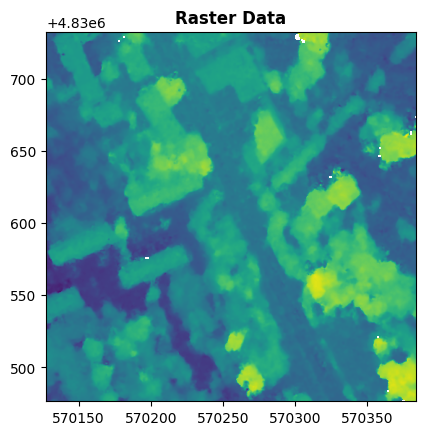

input data shape : (1, 512, 512) (bands, height, width)


In [1]:
import rasterio
from rasterio.plot import show

def show_raster(input_image:str):
    with rasterio.open(input_image) as src:
        raster_data = src.read()
        show(src, title="Raster Data")
        print(f"input data shape : {raster_data.shape} (bands, height, width)")

input_image_path: str = "../../../examples/data/dsm.tif"
show_raster(input_image_path)


## Importing libraries

First we have to import EOScale `eo_executors` modules

In [2]:
import eoscale.eo_executors as eoexe
import eoscale.manager as eom

## nodata Filtering

Then we are able to create our first filter: `replace_nodata`.

In [3]:
import numpy
from typing import List

def nodata_filter(input_buffers: List, 
                  input_profiles: List[rasterio.profiles.Profile], 
                  params: dict) -> numpy.ndarray :
    print(f"len(input_buffers): {len(input_buffers)}\n")
    print(f"chunk shape: {input_buffers[0].shape}\n")
    input_img = input_buffers[0]
    return numpy.where(input_img[0] == input_profiles[0]["nodata"], params["replaced_nodata"], 0 ).astype(numpy.uint8)

def nodata_profile(input_profiles: List[rasterio.profiles.Profile],
                   params: dict) -> dict:
    mask_profile = input_profiles[0]
    mask_profile['dtype'] = numpy.uint8
    mask_profile['nodata'] = None
    print(f"Profile {mask_profile}\n")
    return mask_profile

def replace_nodata(imgs:List[str], context:eom.EOContextManager):
    return eoexe.n_images_to_m_images_filter(inputs = imgs,
                                             image_filter = nodata_filter,
                                             generate_output_profiles = nodata_profile,
                                             context_manager = context,
                                             filter_parameters = {"replaced_nodata":1},
                                             filter_desc= "Nodata processing...")

### n_images_to_m_images_filter arguments

n_images_to_m_images_filter must be feed with at least 4 arguments : `inputs`, `image_filter`, `generate_output_profiles` and `context_manager`. Feel free to hit `Shift + Tab` to get the full `n_images_to_m_images_filter` signature.

#### inputs

Must contains a list of unique key (provided by `eom.EOContextManager.open_raster`) which allow EOScale to access data inside its context

#### context_manager

Instance of the EOScale `EOContextManager` context manager responsible for data management.

#### image_filter

Is a Callable responsible to process the data. This function will receive 3 parameters `input_buffers`, `input_profiles` and `params`

- input_buffers

  is a list of chunk as numpy array from input images. This list is as long as inputs. 
  
- input_profiles

  is a [rasterio Profile](https://rasterio.readthedocs.io/en/latest/api/rasterio.profiles.html#rasterio.profiles.Profile) for each inputs.

- params

  is a dictionnary provided by users

#### generate_output_profiles

Is a Callable responsible to shape the output data by returning a list of [rasterio Profile](https://rasterio.readthedocs.io/en/latest/api/rasterio.profiles.html#rasterio.profiles.Profile)

#### filter_parameters

is a dictionnary of parameters to pass to the image_filter Callable.


## Read data, apply filter and write results

Our filter ready, we can use it inside a EOContextManager.


Profile {'driver': 'GTiff', 'dtype': <class 'numpy.uint8'>, 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.5, 0.0, 570127.5,
       0.0, -0.5, 4830732.5), 'blockysize': 4, 'tiled': False, 'interleave': 'band'}



Nodata processing...:   0%|                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]

len(input_buffers): 1
len(input_buffers): 1


chunk shape: (1, 362, 150)

chunk shape: (1, 362, 362)

len(input_buffers): 1

chunk shape: (1, 150, 362)

len(input_buffers): 1

chunk shape: (1, 150, 150)



Nodata processing...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 124.35it/s]

(1, 512, 512)


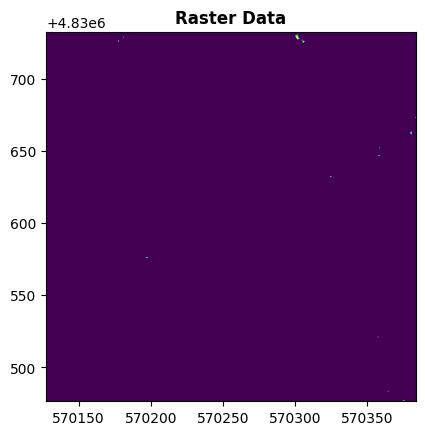

input data shape : (1, 512, 512) (bands, height, width)


In [4]:
nb_workers: int = 2
tile_mode: bool = True
with eom.EOContextManager(nb_workers = nb_workers, tile_mode = tile_mode) as eoscale_manager:
    img_1 = eoscale_manager.open_raster(raster_path = input_image_path)
    keys = replace_nodata([img_1], eoscale_manager)
    arr = eoscale_manager.get_array(keys[0])
    print(arr.shape)
    eoscale_manager.write(key = keys[0], img_path = "replace_nodata.tif")
show_raster("replace_nodata.tif")

The `EOContextManager` context manager is set to split inputs into tiles (`tile_mode : bool = True`) over 2 workers. If `tile_mode` is False, then inputs will be split into strips. To illustrate data manipulated by `image_filter` callable, prints has been added into the `nodata_filter` function.

As you can observe, `nodata_filter` is called several times with different chunk shapes. Processing is triggered as soon as `n_images_to_m_images_filter` is called and you can retrieve the data using the `EOContextManager.get_array` method.

## Chain filters

a usefull EOScale feature is its ability to chain filter without any disk access between them. To illustrate it, let's create a new simple filter 

In [5]:
def add_filter(input_buffers: List, 
               input_profiles: List[rasterio.profiles.Profile], 
               params: dict) -> numpy.ndarray :
    return input_buffers[0] + params.get("add_value", 10)

def add_profile(input_profiles: List[rasterio.profiles.Profile],
                   params: dict) -> dict:
    mask_profile = input_profiles[0]
    mask_profile['dtype'] = numpy.uint8
    mask_profile['nodata'] = None
    print(f"Profile {mask_profile}\n")
    return mask_profile

def add_value(imgs:List[str], context:eom.EOContextManager):
    return eoexe.n_images_to_m_images_filter(inputs = imgs,
                                             image_filter = add_filter,
                                             generate_output_profiles = add_profile,
                                             context_manager = context,
                                             filter_parameters = {"add_value":2},
                                             filter_desc= "Add value to data...")
nb_workers: int = 2
tile_mode: bool = True
with eom.EOContextManager(nb_workers = nb_workers, tile_mode = tile_mode) as eoscale_manager:
    img_1 = eoscale_manager.open_raster(raster_path = input_image_path)
    keys = replace_nodata([img_1], eoscale_manager)
    add_keys = add_value([keys[0]], eoscale_manager)
    max_value = numpy.max(eoscale_manager.get_array(add_keys[0]))
    print(f"Maximum value: {max_value}")

Profile {'driver': 'GTiff', 'dtype': <class 'numpy.uint8'>, 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.5, 0.0, 570127.5,
       0.0, -0.5, 4830732.5), 'blockysize': 4, 'tiled': False, 'interleave': 'band'}



Nodata processing...:   0%|                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]

len(input_buffers): 1
len(input_buffers): 1


chunk shape: (1, 362, 362)
chunk shape: (1, 362, 150)


len(input_buffers): 1
len(input_buffers): 1


chunk shape: (1, 150, 362)
chunk shape: (1, 150, 150)




Nodata processing...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 191.86it/s]

Profile {'driver': 'GTiff', 'dtype': <class 'numpy.uint8'>, 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.5, 0.0, 570127.5,
       0.0, -0.5, 4830732.5), 'blockysize': 4, 'tiled': False, 'interleave': 'band'}




Add value to data...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1257.76it/s]

Maximum value: 3


```bash
Maximum value: 3
```

Is the expected value as the previous filter produce an array containing 0 or 1.